# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import clear_output

from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

import tqdm

In [2]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data logs setup
writer = SummaryWriter()

# Load and split data

In [3]:
# data transformation
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:05<00:00, 29.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [64]:
def show_sample_images(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        image, label = dataset[i]
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(f"Class: {label}")
        axes[i].axis('off')
    plt.show()

In [ ]:
show_sample_images(train_dataset, 10)
show_sample_images(test_dataset, 10)

# Models setup

In [4]:
class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), 256 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [5]:
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [10]:
# train and eval loops

def train_model(model, trainloader, criterion, optimizer, epochs, eval_freq=10):
    # setting up parameters to log
    train_loss_history = []
    train_f1_history = []
    eval_loss_history = []
    eval_f1_history = []
    global_step = 0

    model.train()
    for epoch in tqdm.tqdm(range(epochs)):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            #log_probs = model(i.to(device))
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            #preliminary eval
            probs = F.softmax(outputs, dim=1)
            preds = probs.argmax(dim=1).cpu().tolist()
            f1 = f1_score(labels.cpu().tolist(), preds, average='weighted')

            train_loss_history.append((global_step, loss.item()))
            train_f1_history.append((global_step, f1))

            running_loss += loss.item()
            if i % 100 == 99:
                writer.add_scalar('Training/Loss', running_loss / 100, global_step)
                writer.add_scalar('Training/F1', f1, global_step)
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

            # plot loss and f1
            if global_step % 250 == 0:
                  clear_output(True)

                  plt.figure(figsize=(15, 5))

                  plt.subplot(121)
                  plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
                  if len(eval_loss_history):
                      plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
                  plt.legend()

                  plt.subplot(122)
                  plt.plot(*zip(*train_f1_history), alpha=0.5, label='train_f1')
                  if len(eval_f1_history):
                      plt.plot(*zip(*eval_f1_history), color='red', label='eval_f1')
                  plt.legend()
                  plt.show()

            global_step += 1


In [53]:
@torch.no_grad()
def evaluate_model(model, loader=testloader, loss_function = nn.CrossEntropyLoss()):
    model.eval()
    loss_epoch = 0.
    num_epoch = 0.
    preds_list = []
    targets_list = []

    for batch_X, target in tqdm.tqdm(loader):
      log_probs, _= model(batch_X.to(device))
      loss = loss_function(log_probs, target.to(device))
      num = log_probs.shape[0]
      loss_epoch += loss.item() * num
      num_epoch += num

      preds_list += log_probs.argmax(dim=1).cpu().tolist()
      targets_list += target.cpu().tolist()

    avg_loss = loss_epoch / num_epoch
    f1 = f1_score(preds_list, targets_list, average='weighted')
    precision = precision_score(preds_list, targets_list, average='weighted')
    recall = recall_score(preds_list, targets_list, average='weighted')
    print(classification_report(targets_list, preds_list))

    # Log metrics to TensorBoard
    writer.add_scalar('Evaluation/Loss', avg_loss)
    writer.add_scalar('Evaluation/F1', f1)
    writer.add_scalar('Evaluation/Precision', precision)
    writer.add_scalar('Evaluation/Recall', recall)

    writer.close()

    return avg_loss, precision, recall, f1

# Models train and evaluation

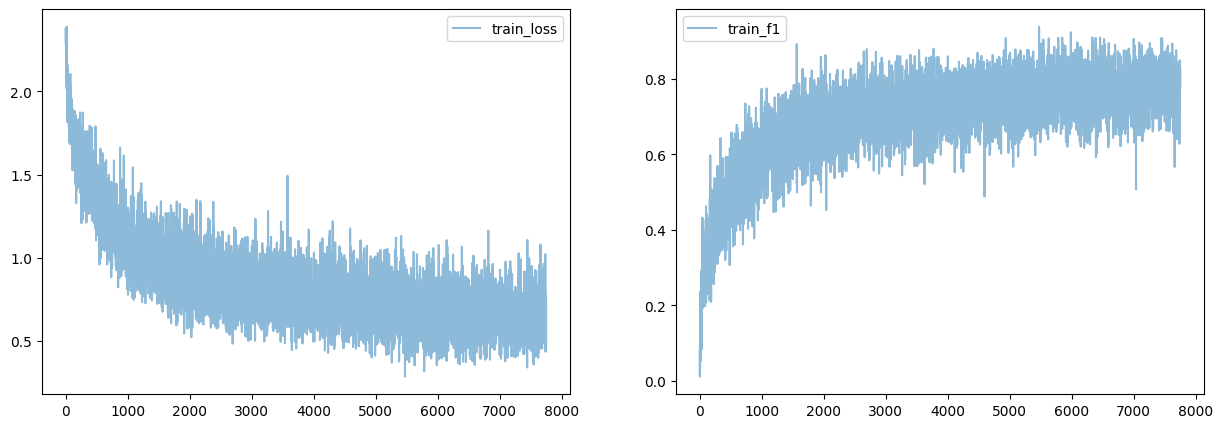

100%|██████████| 10/10 [04:48<00:00, 28.83s/it]


In [11]:
teacher_model = TeacherModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher_model.parameters())
train_model(teacher_model, trainloader, criterion, optimizer, epochs=10)

In [17]:
teacher_loss, teacher_precision, teacher_recall, teacher_f1 = evaluate_model(teacher_model, testloader)

print(f"Teacher Model Precision: {teacher_precision}")
print(f"Teacher Model Recall: {teacher_recall}")
print(f"Teacher Model F1: {teacher_f1}")

100%|██████████| 157/157 [00:04<00:00, 39.10it/s]

              precision    recall  f1-score   support

           0       0.86      0.76      0.81      1000
           1       0.93      0.84      0.88      1000
           2       0.70      0.71      0.70      1000
           3       0.59      0.65      0.62      1000
           4       0.77      0.76      0.76      1000
           5       0.76      0.67      0.71      1000
           6       0.84      0.82      0.83      1000
           7       0.77      0.85      0.81      1000
           8       0.79      0.92      0.85      1000
           9       0.86      0.84      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000

Teacher Model Precision: 0.7845253000000001
Teacher Model Recall: 0.7822
Teacher Model F1: 0.781580757297395


In [18]:
!tensorboard --logdir=runs

2025-01-10 15:35:24.736643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-10 15:35:24.769835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-10 15:35:24.779905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 15:35:26.932983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1736523329.342055    4636 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/b

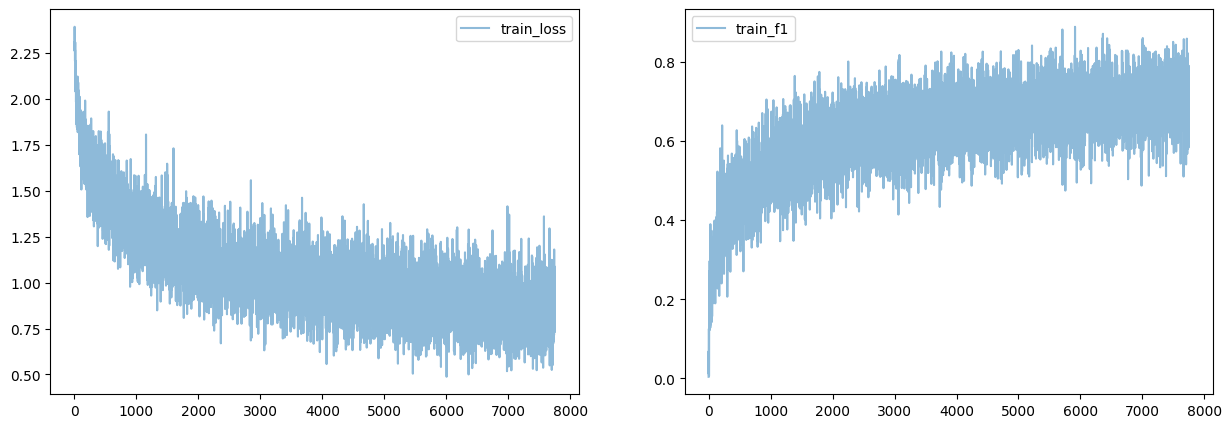

100%|██████████| 10/10 [04:18<00:00, 25.82s/it]


In [19]:
student_model = StudentModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters())
train_model(student_model, trainloader, criterion, optimizer, epochs=10)

In [20]:
student_loss, student_precision, student_recall, student_f1 = evaluate_model(student_model, testloader)

print(f"Student Model Precision: {student_precision}")
print(f"Student Model Recall: {student_recall}")
print(f"Student Model F1: {student_f1}")

100%|██████████| 157/157 [00:03<00:00, 39.41it/s]

              precision    recall  f1-score   support

           0       0.76      0.73      0.74      1000
           1       0.83      0.84      0.83      1000
           2       0.56      0.64      0.60      1000
           3       0.49      0.57      0.53      1000
           4       0.69      0.62      0.65      1000
           5       0.75      0.41      0.53      1000
           6       0.70      0.85      0.77      1000
           7       0.80      0.73      0.76      1000
           8       0.78      0.86      0.81      1000
           9       0.78      0.81      0.80      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.70     10000
weighted avg       0.71      0.71      0.70     10000

Student Model Precision: 0.7221122
Student Model Recall: 0.7062
Student Model F1: 0.7093896954039888


# Experiments

### 1. Logit distillation

In [23]:
def distill_function(teacher_model, student_model, trainloader, temperature=4.0, alpha=0.5, epochs=10):
    teacher_model.eval()
    student_model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student_model.parameters())

    # setting up parameters to log
    train_loss_history, train_f1_history = [], []
    eval_loss_history, eval_f1_history = [], []
    global_step = 0

    for epoch in tqdm.tqdm(range(epochs)):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Получаем soft targets от учителя
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)

            # Получаем выходы студента
            student_outputs = student_model(inputs)

            # Вычисляем мягкие метки (soft targets)
            soft_targets = F.softmax(teacher_outputs / temperature, dim=1)
            soft_prob = F.log_softmax(student_outputs / temperature, dim=1)

            # Считаем две компоненты потерь
            distillation_loss = F.kl_div(soft_prob, soft_targets, reduction='batchmean') * (temperature ** 2)
            student_loss = criterion(student_outputs, labels)

            # Комбинируем потери
            loss = alpha * student_loss + (1 - alpha) * distillation_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #preliminary eval
            probs = F.softmax(student_outputs, dim=1)
            preds = probs.argmax(dim=1).cpu().tolist()
            f1 = f1_score(labels.cpu().tolist(), preds, average='weighted')

            train_loss_history.append((global_step, loss.item()))
            train_f1_history.append((global_step, f1))

            running_loss += loss.item()
            if i % 100 == 99:
                writer.add_scalar('Training/Loss', running_loss / 100, global_step)
                writer.add_scalar('Training/F1', f1, global_step)
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

            # plot loss and f1
            if global_step % 250 == 0:
                  clear_output(True)

                  plt.figure(figsize=(15, 5))

                  plt.subplot(121)
                  plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
                  if len(eval_loss_history):
                      plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
                  plt.legend()

                  plt.subplot(122)
                  plt.plot(*zip(*train_f1_history), alpha=0.5, label='train_f1')
                  if len(eval_f1_history):
                      plt.plot(*zip(*eval_f1_history), color='red', label='eval_f1')
                  plt.legend()
                  plt.show()

            global_step += 1

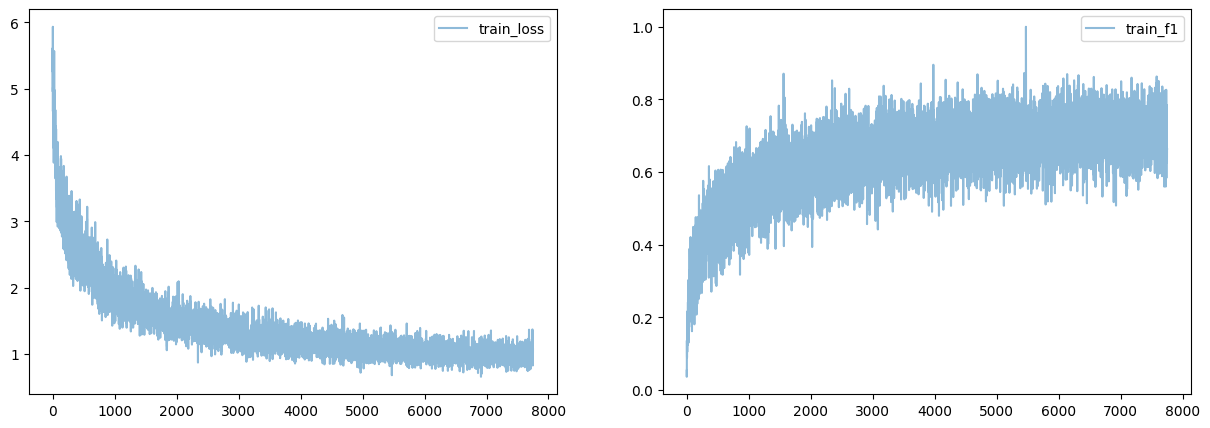

100%|██████████| 10/10 [04:34<00:00, 27.42s/it]


In [24]:
student_model_distilled = StudentModel().to(device)

distill_function(teacher_model, student_model_distilled, trainloader)

In [25]:
destill_loss, destill_precision, destill_recall, destill_f1 = evaluate_model(student_model_distilled, testloader)

print(f"Destilled Model Precision: {destill_precision}")
print(f"Destilled Model Recall: {destill_recall}")
print(f"Destilled Model F1: {destill_f1}")

100%|██████████| 157/157 [00:04<00:00, 37.99it/s]


              precision    recall  f1-score   support

           0       0.80      0.68      0.73      1000
           1       0.89      0.82      0.85      1000
           2       0.59      0.60      0.59      1000
           3       0.48      0.58      0.53      1000
           4       0.74      0.63      0.68      1000
           5       0.71      0.54      0.61      1000
           6       0.66      0.86      0.75      1000
           7       0.80      0.75      0.78      1000
           8       0.75      0.89      0.82      1000
           9       0.83      0.80      0.82      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000

Destilled Model Precision: 0.7248220000000001
Destilled Model Recall: 0.7148
Destilled Model F1: 0.7147732460628974


### 2. Immitation hidden state

In [34]:
class TeacherModel2(nn.Module):
    def __init__(self):
        super(TeacherModel2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Extracting features before the fully connected layers
        features = x

        x = x.view(x.size(0), 256 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x, features

class StudentModel2(nn.Module):
    def __init__(self):
        super(StudentModel2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Adding a 1x1 convolution to match the teacher's feature map channels
        self.conv3 = nn.Conv2d(64, 256, kernel_size=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))

        # Extracting features before the fully connected layers
        features = x

        x = x.view(x.size(0), 256 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x, features

In [26]:
# Функция для адаптации размерности признаков с помощью пулинга
def adapt_features(student_feature, teacher_feature):
    if len(student_feature.shape) == 4:  # Для сверточных слоев
        return F.adaptive_avg_pool2d(student_feature, teacher_feature.shape[2:])
    return student_feature  # Для полносвязных слоев

In [27]:
# Функция потерь для скрытых состояний
class HiddenStateLoss(nn.Module):
    def __init__(self, weights=None):
        super(HiddenStateLoss, self).__init__()
        self.weights = weights if weights is not None else [1.0, 1.0, 1.0]

    def forward(self, student_features, teacher_features):
        losses = []
        for sf, tf, w in zip(student_features, teacher_features, self.weights):
            adapted_sf = adapt_features(sf, tf)
            # Нормализация признаков
            adapted_sf = F.normalize(adapted_sf.view(adapted_sf.size(0), -1), dim=1)
            tf = F.normalize(tf.view(tf.size(0), -1), dim=1)
            # Используем MSE loss для сравнения признаков
            loss = F.mse_loss(adapted_sf, tf)
            losses.append(w * loss)
        return sum(losses)


In [28]:
def train_hidden_state_matching(teacher_model, student_model, trainloader, epochs=10):
    teacher_model.eval()  # Учитель в режиме оценки
    student_model.train()  # Студент в режиме обучения

    # setting up parameters to log
    train_loss_history, train_f1_history = [], []
    eval_loss_history, eval_f1_history = [], []
    global_step = 0

    # Веса для разных уровней скрытых состояний
    hidden_weights = [0.2, 0.4, 0.4]  # Больший вес для более глубоких слоев

    criterion = nn.CrossEntropyLoss()
    hidden_criterion = HiddenStateLoss(weights=hidden_weights)
    optimizer = optim.Adam(student_model.parameters())

    alpha = 0.5  # Баланс между loss классификации и loss скрытых состояний

    for epoch in tqdm.tqdm(range(epochs)):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Получаем выходы и скрытые состояния учителя
            with torch.no_grad():
                teacher_outputs, teacher_features = teacher_model(inputs)

            # Получаем выходы и скрытые состояния студента
            student_outputs, student_features = student_model(inputs)

            # Вычисляем обе компоненты loss
            classification_loss = criterion(student_outputs, labels)
            hidden_loss = hidden_criterion(student_features, teacher_features)

            # Общая loss
            loss = alpha * classification_loss + (1 - alpha) * hidden_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #preliminary eval
            probs = F.softmax(student_outputs, dim=1)
            preds = probs.argmax(dim=1).cpu().tolist()
            f1 = f1_score(labels.cpu().tolist(), preds, average='weighted')

            train_loss_history.append((global_step, loss.item()))
            train_f1_history.append((global_step, f1))

            running_loss += loss.item()
            if i % 100 == 99:
                writer.add_scalar('Training/Loss', running_loss / 100, global_step)
                writer.add_scalar('Training/F1', f1, global_step)
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

            # plot loss and f1
            if global_step % 250 == 0:
                  clear_output(True)

                  plt.figure(figsize=(15, 5))

                  plt.subplot(121)
                  plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
                  if len(eval_loss_history):
                      plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
                  plt.legend()

                  plt.subplot(122)
                  plt.plot(*zip(*train_f1_history), alpha=0.5, label='train_f1')
                  if len(eval_f1_history):
                      plt.plot(*zip(*eval_f1_history), color='red', label='eval_f1')
                  plt.legend()
                  plt.show()

            global_step += 1


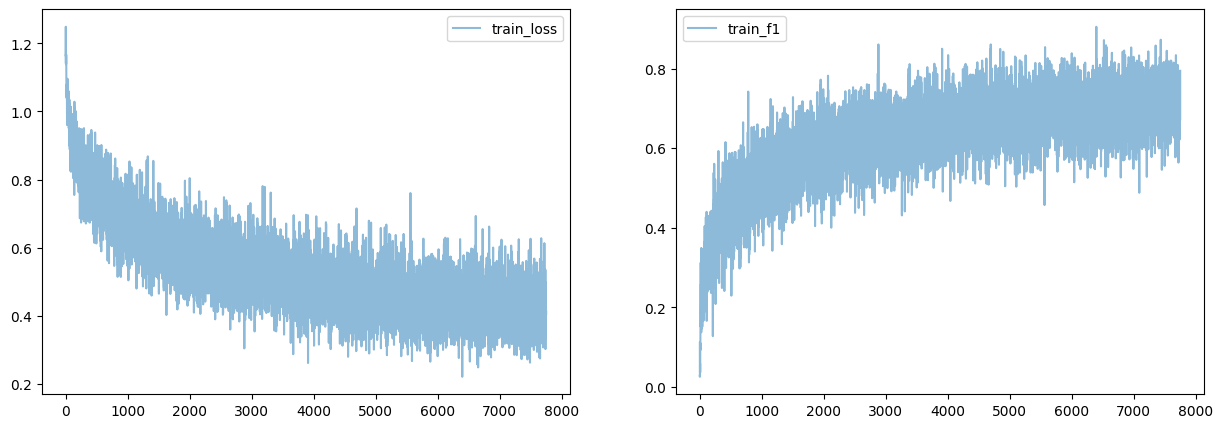

100%|██████████| 10/10 [04:41<00:00, 28.14s/it]


In [36]:
# Обучение с совпадением скрытых состояний
teacher_model_2 = TeacherModel2().to(device)
student_model_2 = StudentModel2().to(device)

print("Training student model with hidden state matching...")
train_hidden_state_matching(teacher_model_2, student_model_2, trainloader)

In [40]:
# Оценка результатов
student_loss, student_precision, student_recall, student_f1 = evaluate_model(student_model_2, testloader)

print(f"Student Model Precision: {student_precision}")
print(f"Student Model Recall: {student_recall}")
print(f"Student Model F1: {student_f1}")

100%|██████████| 157/157 [00:03<00:00, 40.68it/s]

              precision    recall  f1-score   support

           0       0.74      0.77      0.75      1000
           1       0.83      0.89      0.86      1000
           2       0.72      0.50      0.59      1000
           3       0.59      0.44      0.50      1000
           4       0.68      0.73      0.70      1000
           5       0.54      0.76      0.63      1000
           6       0.80      0.76      0.78      1000
           7       0.77      0.77      0.77      1000
           8       0.85      0.84      0.84      1000
           9       0.82      0.84      0.83      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000

Student Model Precision: 0.7463101
Student Model Recall: 0.729
Student Model F1: 0.7322828295080955


### 3. Add regressor

In [42]:
class FeatureRegressor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FeatureRegressor, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.bn(self.conv(x))

In [43]:
class TeacherNet(nn.Module):
    def __init__(self):
        super(TeacherNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def get_features(self, x):
        x = F.relu(self.conv1(x))
        f1 = x  # 64 channels

        x = self.pool(F.relu(self.conv2(x)))
        f2 = x  # 128 channels

        x = self.pool(F.relu(self.conv3(x)))
        f3 = x  # 256 channels

        return [f1, f2, f3]

    def forward(self, x):
        features = self.get_features(x)

        x = features[-1]
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x, features

In [44]:
class StudentNetWithRegressor(nn.Module):
    def __init__(self):
        super(StudentNetWithRegressor, self).__init__()
        # Основная архитектура студента
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.3)

        # Регрессоры для каждого уровня признаков
        self.regressor1 = FeatureRegressor(32, 64)
        self.regressor2 = FeatureRegressor(64, 128)
        self.regressor3 = FeatureRegressor(64, 256)

    def get_features(self, x):
        # Оригинальные признаки студента
        x = F.relu(self.conv1(x))
        f1 = x  # 32 channels

        x = self.pool(F.relu(self.conv2(x)))
        f2 = x  # 64 channels

        x = self.pool(x)
        f3 = x  # 64 channels

        return [f1, f2, f3]

    def get_regressed_features(self, features):
        # Применяем регрессоры к признакам
        r1 = self.regressor1(features[0])  # 32->64
        r2 = self.regressor2(features[1])  # 64->128
        r3 = self.regressor3(features[2])  # 64->256

        return [r1, r2, r3]

    def forward(self, x):
        features = self.get_features(x)
        regressed_features = self.get_regressed_features(features)

        # Для классификации используем последний слой признаков
        x = features[-1]
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x, features, regressed_features

In [45]:
class CombinedLoss(nn.Module):
    def __init__(self, feature_weights=[0.2, 0.3, 0.5]):
        super(CombinedLoss, self).__init__()
        self.feature_weights = feature_weights
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_output, target, student_regressed_features, teacher_features):
        # Loss классификации
        ce_loss = self.ce_loss(student_output, target)

        # Loss регрессии признаков
        feature_loss = 0
        for sf, tf, w in zip(student_regressed_features, teacher_features, self.feature_weights):
            # Используем adaptive_avg_pool2d для соответствия размерностей
            sf = F.adaptive_avg_pool2d(sf, tf.shape[2:])
            feature_loss += w * F.mse_loss(sf, tf)

        return ce_loss, feature_loss

In [41]:
def train_with_regressor(teacher_model, student_model, trainloader, epochs=10):
    teacher_model.eval()
    student_model.train()

    # setting up parameters to log
    train_loss_history, train_f1_history = [], []
    eval_loss_history, eval_f1_history = [], []
    global_step = 0

    combined_criterion = CombinedLoss()
    optimizer = optim.Adam(student_model.parameters())

    alpha = 0.5  # Вес между classification loss и feature regression loss

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Получаем признаки учителя
            with torch.no_grad():
                _, teacher_features = teacher_model(inputs)

            # Прямой проход студента
            student_outputs, _, student_regressed_features = student_model(inputs)

            # Вычисляем losses
            ce_loss, feature_loss = combined_criterion(
                student_outputs, labels,
                student_regressed_features, teacher_features
            )

            # Общая loss
            loss = alpha * ce_loss + (1 - alpha) * feature_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #preliminary eval
            probs = F.softmax(student_outputs, dim=1)
            preds = probs.argmax(dim=1).cpu().tolist()
            f1 = f1_score(labels.cpu().tolist(), preds, average='weighted')

            train_loss_history.append((global_step, loss.item()))
            train_f1_history.append((global_step, f1))

            running_loss += loss.item()
            if i % 100 == 99:
                writer.add_scalar('Training/Loss', running_loss / 100, global_step)
                writer.add_scalar('Training/F1', f1, global_step)
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

            # plot loss and f1
            if global_step % 250 == 0:
                  clear_output(True)

                  plt.figure(figsize=(15, 5))

                  plt.subplot(121)
                  plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
                  if len(eval_loss_history):
                      plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
                  plt.legend()

                  plt.subplot(122)
                  plt.plot(*zip(*train_f1_history), alpha=0.5, label='train_f1')
                  if len(eval_f1_history):
                      plt.plot(*zip(*eval_f1_history), color='red', label='eval_f1')
                  plt.legend()
                  plt.show()

            global_step += 1



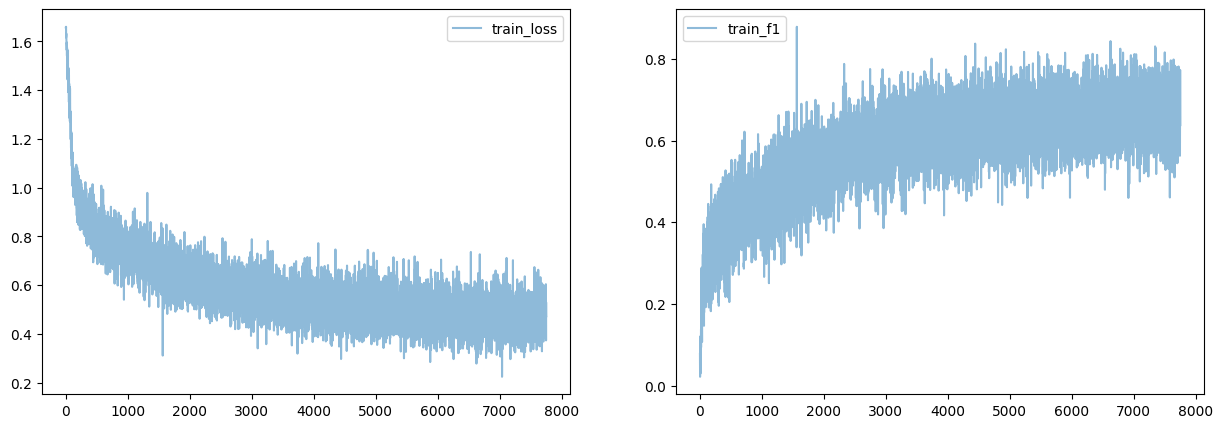

In [46]:
teacher_model3 = TeacherNet().to(device)
student_model3 = StudentNetWithRegressor().to(device)

print("Training student model with feature regression...")
train_with_regressor(teacher_model3, student_model3, trainloader)

In [50]:
# Оценка результатов
student_loss, student_precision, student_recall, student_f1 = evaluate_model(student_model3, testloader)

print(f"Student Model Precision: {student_precision}")
print(f"Student Model Recall: {student_recall}")
print(f"Student Model F1: {student_f1}")

100%|██████████| 157/157 [00:05<00:00, 27.33it/s]

              precision    recall  f1-score   support

           0       0.68      0.76      0.72      1000
           1       0.76      0.87      0.81      1000
           2       0.62      0.52      0.57      1000
           3       0.50      0.54      0.52      1000
           4       0.68      0.58      0.63      1000
           5       0.65      0.52      0.58      1000
           6       0.73      0.78      0.75      1000
           7       0.74      0.70      0.72      1000
           8       0.77      0.84      0.81      1000
           9       0.74      0.78      0.76      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000

Student Model Precision: 0.7015378000000001
Student Model Recall: 0.6892
Student Model F1: 0.6930050541279176


### 4. Increase epochs

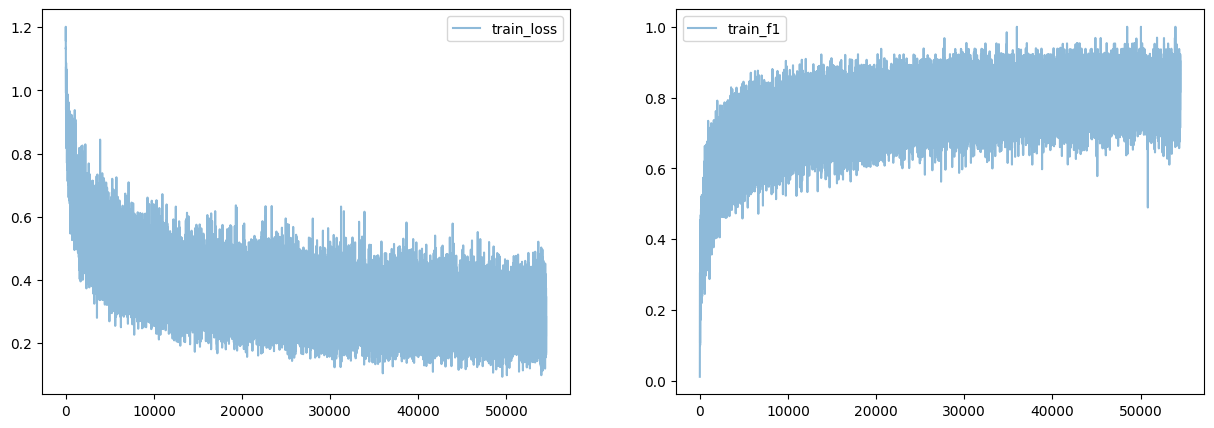

[70,   600] loss: 0.272
[70,   700] loss: 0.270


100%|██████████| 70/70 [34:24<00:00, 29.49s/it]


In [51]:
# Обучение с совпадением скрытых состояний
teacher_model_2 = TeacherModel2().to(device)
student_model_2 = StudentModel2().to(device)

print("Training student model with hidden state matching...")
train_hidden_state_matching(teacher_model_2, student_model_2, trainloader, epochs=70)

In [54]:
# Оценка результатов
student_loss, student_precision, student_recall, student_f1 = evaluate_model(student_model_2, testloader)

print(f"Student Model Precision: {student_precision}")
print(f"Student Model Recall: {student_recall}")
print(f"Student Model F1: {student_f1}")

100%|██████████| 157/157 [00:06<00:00, 25.87it/s]

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1000
           1       0.91      0.89      0.90      1000
           2       0.75      0.69      0.72      1000
           3       0.61      0.68      0.64      1000
           4       0.79      0.74      0.76      1000
           5       0.71      0.72      0.72      1000
           6       0.83      0.85      0.84      1000
           7       0.83      0.84      0.84      1000
           8       0.86      0.91      0.89      1000
           9       0.85      0.88      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

Student Model Precision: 0.7981795
Student Model Recall: 0.7973
Student Model F1: 0.7970712187541823
